In [4]:
source('../../source/basic.r')

suppressPackageStartupMessages({
    library(tidyverse)
    library(Signac)
    library(Seurat)
    library(GenomeInfoDb)
    library(EnsDb.Hsapiens.v75)
    library(ggplot2)
    library(patchwork)
    library(data.table)
    library(Matrix)
    set.seed(1234)
})

# seurat object all generation

In [ ]:
seurat.object <- readRDS('data/cpeaks.seuratObject.rds')

In [21]:
# seurat.object <- RunTFIDF(seurat.object)
# seurat.object <- FindTopFeatures(seurat.object, min.cutoff = 'q0')
# seurat.object <- RunSVD(seurat.object)

# DepthCor(seurat.object)

# seurat.object <- RunUMAP(object = seurat.object, reduction = 'lsi', dims = 2:30)
# seurat.object <- FindNeighbors(object = seurat.object, reduction = 'lsi', dims = 2:30)
# seurat.object <- FindClusters(object = seurat.object, verbose = FALSE, algorithm = 3,resolution = 20)
# DimPlot(object = seurat.object, label = TRUE) + NoLegend()
# seurat.object <- FindNeighbors(object = seurat.object, reduction = 'lsi', dims = 2:30)
# # seurat.object <- FindClusters(object = seurat.object, verbose = FALSE, graph.name = 'peaks_snn',resolution = 2,algorithm = 1)
# # DimPlot(object = seurat.object, label = TRUE) + NoLegend()

# psize()

# #seurat.object <- FindNeighbors(object = seurat.object, reduction = 'lsi', dims = 2:30)
# seurat.object <- FindClusters(object = seurat.object, verbose = FALSE, #graph.name = 'peaks_snn',
#                               resolution = 1.4,algorithm = 3)

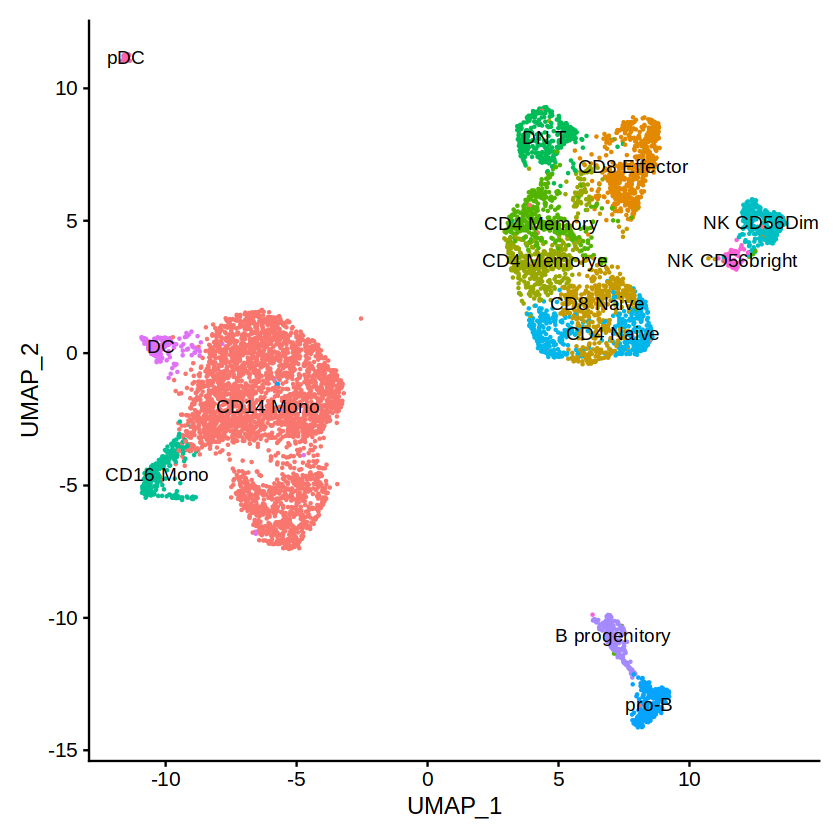

In [6]:
DimPlot(object = seurat.object, label = TRUE) + NoLegend()

In [23]:
# gene.activities <- GeneActivity(seurat.object)

# # add the gene activity matrix to the Seurat object as a new assay and normalize it
# seurat.object[['RNA']] <- CreateAssayObject(counts = gene.activities)
# seurat.object <- NormalizeData(
#   object = seurat.object,
#   assay = 'RNA',
#   normalization.method = 'LogNormalize',
#   scale.factor = median(seurat.object$nCount_RNA)
# )

In [7]:
DefaultAssay(seurat.object) <- 'RNA'

p.feature <- FeaturePlot(
  object = seurat.object,
  features = c('MS4A1', 'CD3D', 'LEF1', 'NKG7', 'TREM1', 'LYZ'),
  pt.size = 0.1,
  max.cutoff = 'q95',
  ncol = 3
)

In [8]:
psize(13,8)

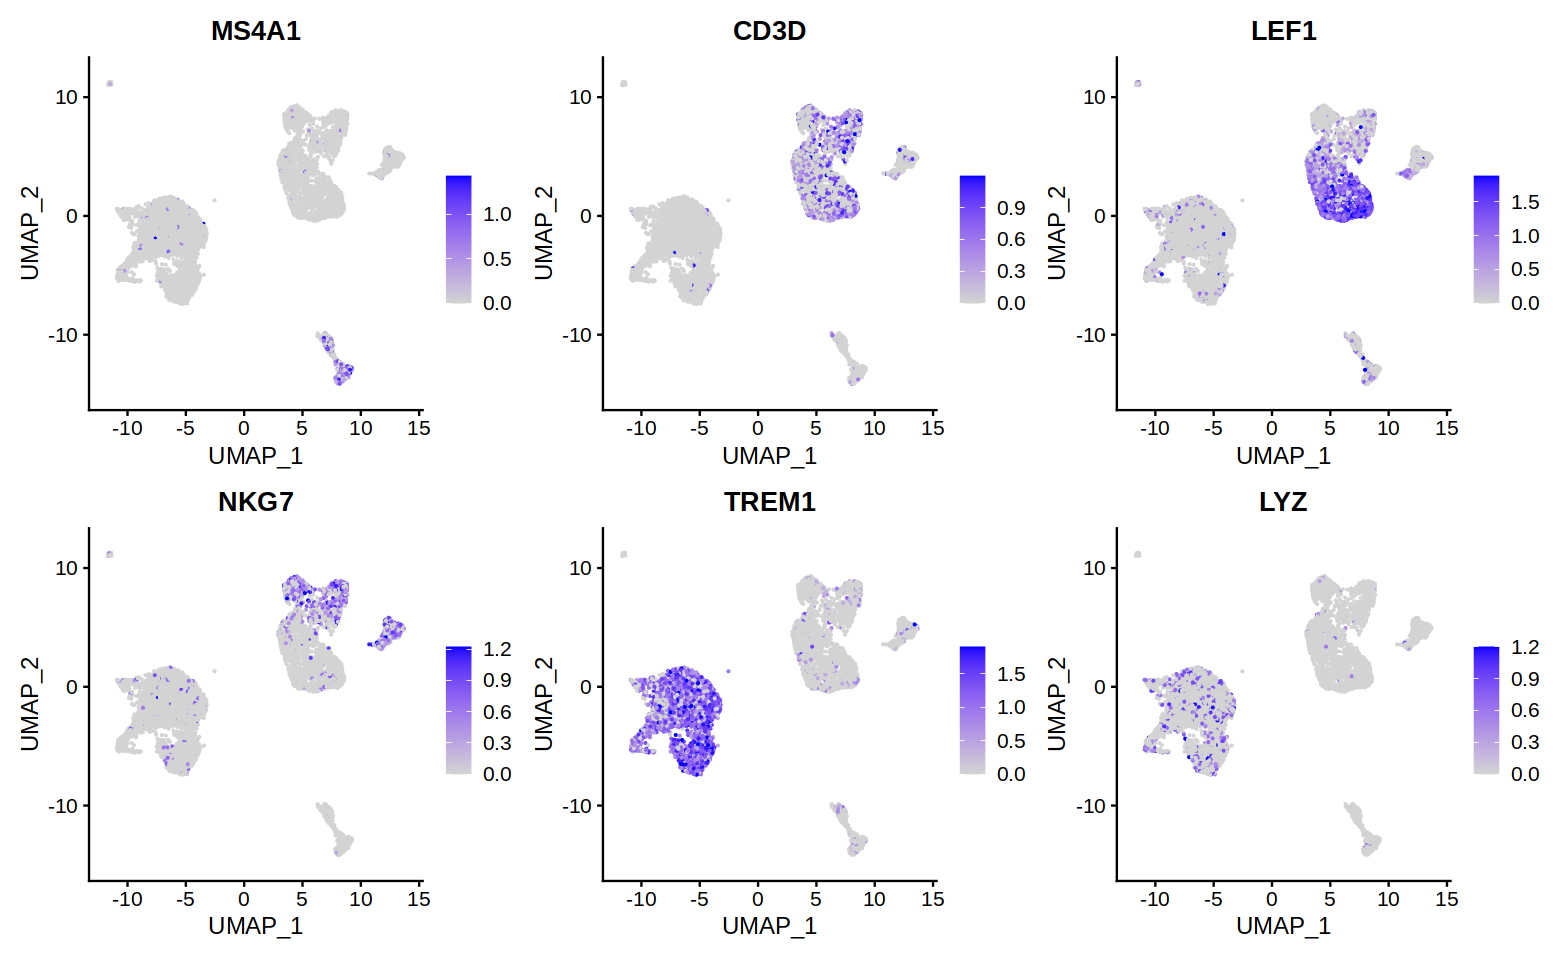

In [9]:
p.feature

In [11]:
# # Load the pre-processed scRNA-seq data for seurat.objects
seurat.object_rna <- readRDS("./data/rna.seuratObject.rds")

transfer.anchors <- FindTransferAnchors(
  reference = seurat.object_rna,
  query = seurat.object,
  reduction = 'cca'
)

predicted.labels <- TransferData(
  anchorset = transfer.anchors,
  refdata = seurat.object_rna$celltype,
  weight.reduction = seurat.object[['lsi']],
  dims = 2:30
)

seurat.object <- AddMetaData(object = seurat.object, metadata = predicted.labels)

Running CCA

Merging objects

Finding neighborhoods

Finding anchors

	Found 17293 anchors

Filtering anchors

	Retained 3987 anchors

Finding integration vectors

Finding integration vector weights

Predicting cell labels



In [12]:
plot1 <- DimPlot(
  object = seurat.object_rna,
  group.by = 'celltype',
  label = TRUE,
  repel = TRUE) + NoLegend() + ggtitle('scRNA-seq')

plot2 <- DimPlot(
  object = seurat.object,
  group.by = 'predicted.id',
  label = TRUE,
  repel = TRUE) + NoLegend() + ggtitle('scATAC-seq')


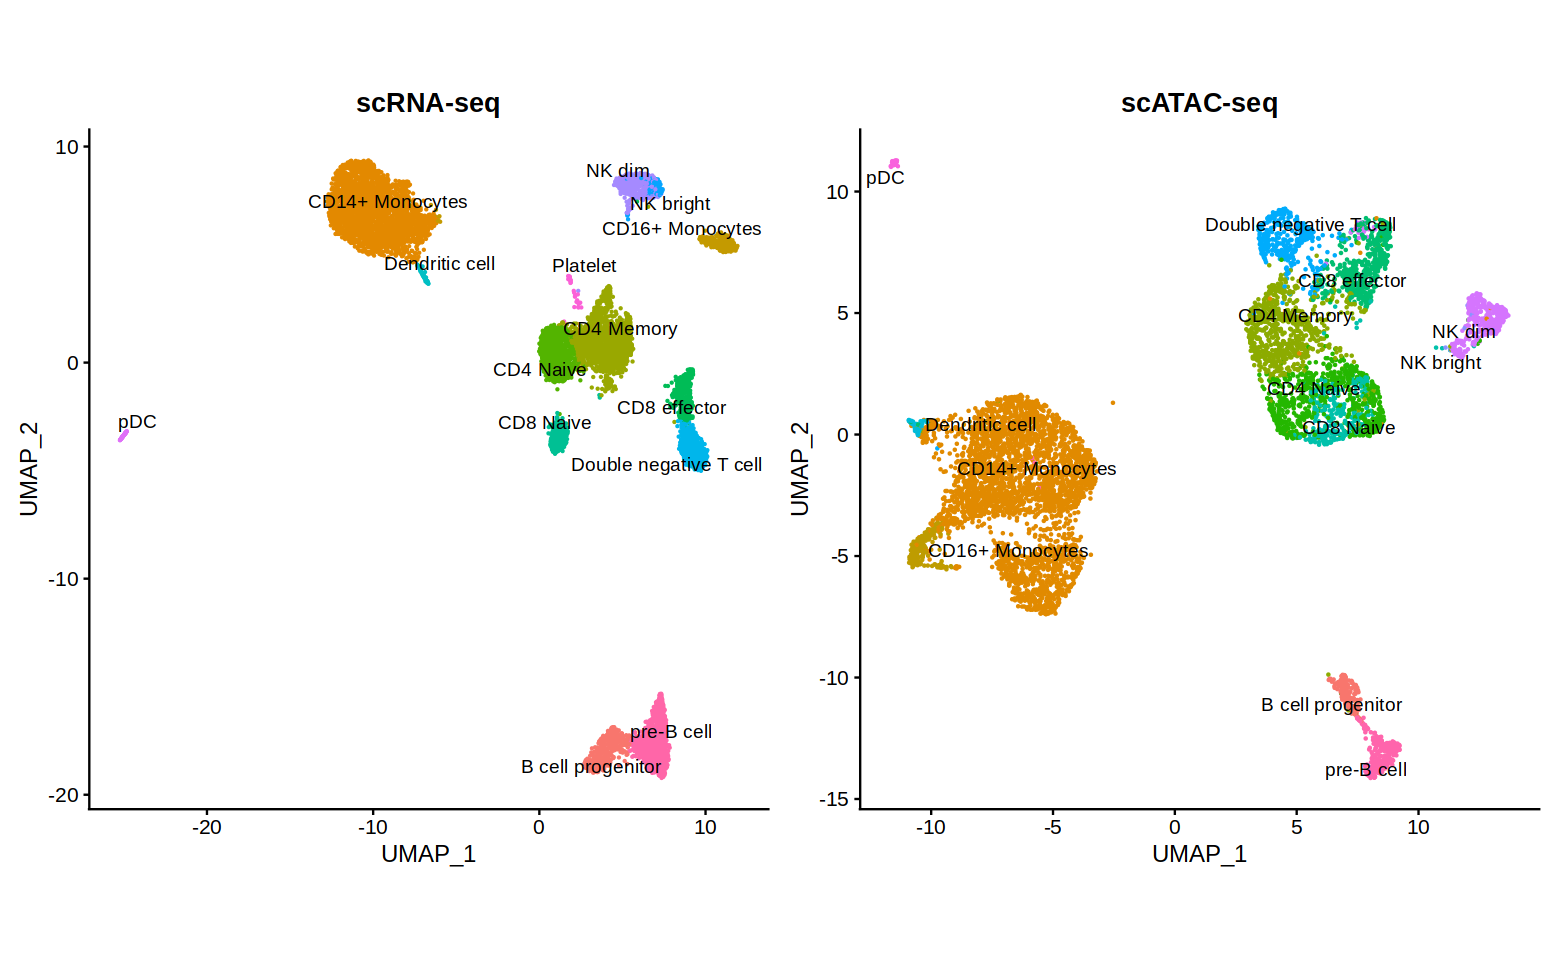

In [168]:
(plot1+theme(aspect.ratio = 1)) + ((plot2+theme(aspect.ratio = 1)))

# rare cell types: pDC

In [45]:
seurat.object@meta.data%>%pull(predicted.id)%>%table

.
     B cell progenitor        CD14+ Monocytes        CD16+ Monocytes 
                   171                   3226                    217 
            CD4 Memory              CD4 Naive           CD8 effector 
                   774                    699                    528 
             CD8 Naive         Dendritic cell Double negative T cell 
                   278                     39                    399 
             NK bright                 NK dim                    pDC 
                     8                    354                     50 
            pre-B cell 
                   285 

## differential accessibility

In [48]:
df.pdc <- seurat.object@meta.data%>%dplyr::filter(predicted.id=='pDC')#%>%table

# change back to working with peaks instead of gene activities
DefaultAssay(seurat.object) <- 'peaks'

da_peaks.pdc <- FindMarkers(
  object = seurat.object,
  ident.1 = "pDC",
  #ident.2 = "CD14 Mono",
  test.use = 'LR',
  latent.vars = 'peak_region_fragments'
)


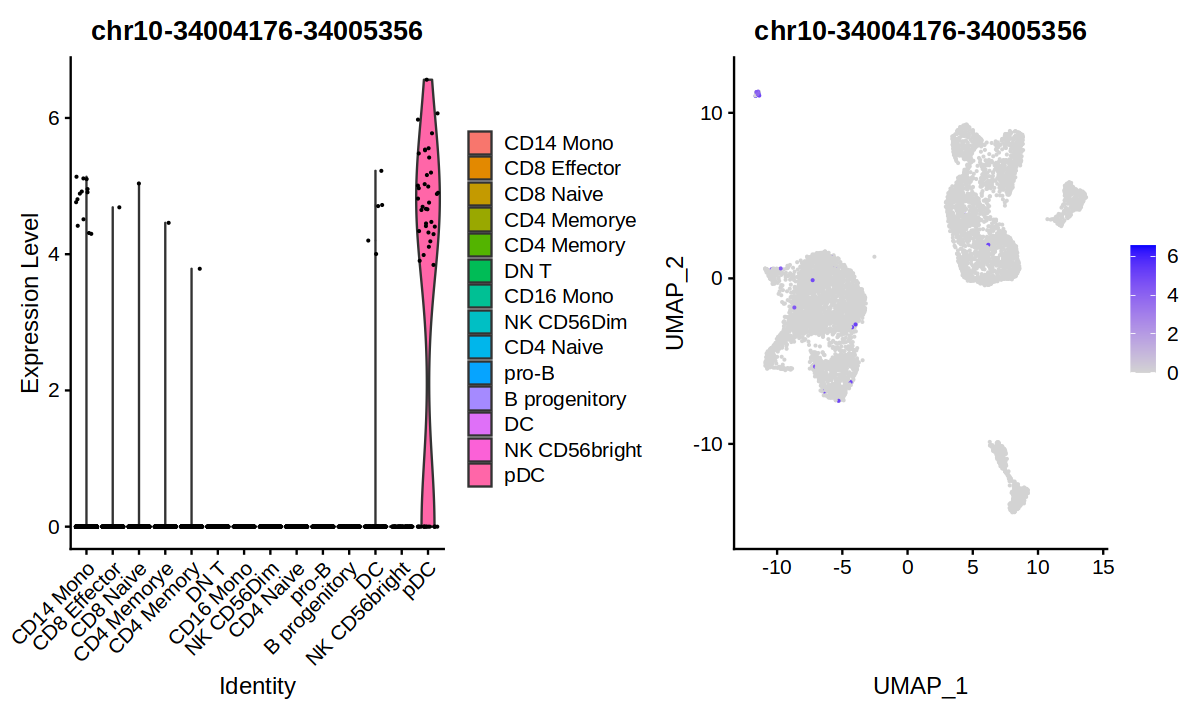

In [57]:
plot1.pda <- VlnPlot(
  object = seurat.object,
  features = rownames(da_peaks.pdc)[1],
  pt.size = 0.1
)
plot2.pda <- FeaturePlot(
  object = seurat.object,
  features = rownames(da_peaks.pdc)[1],
  pt.size = 0.1
)

plot1.pda | plot2.pda

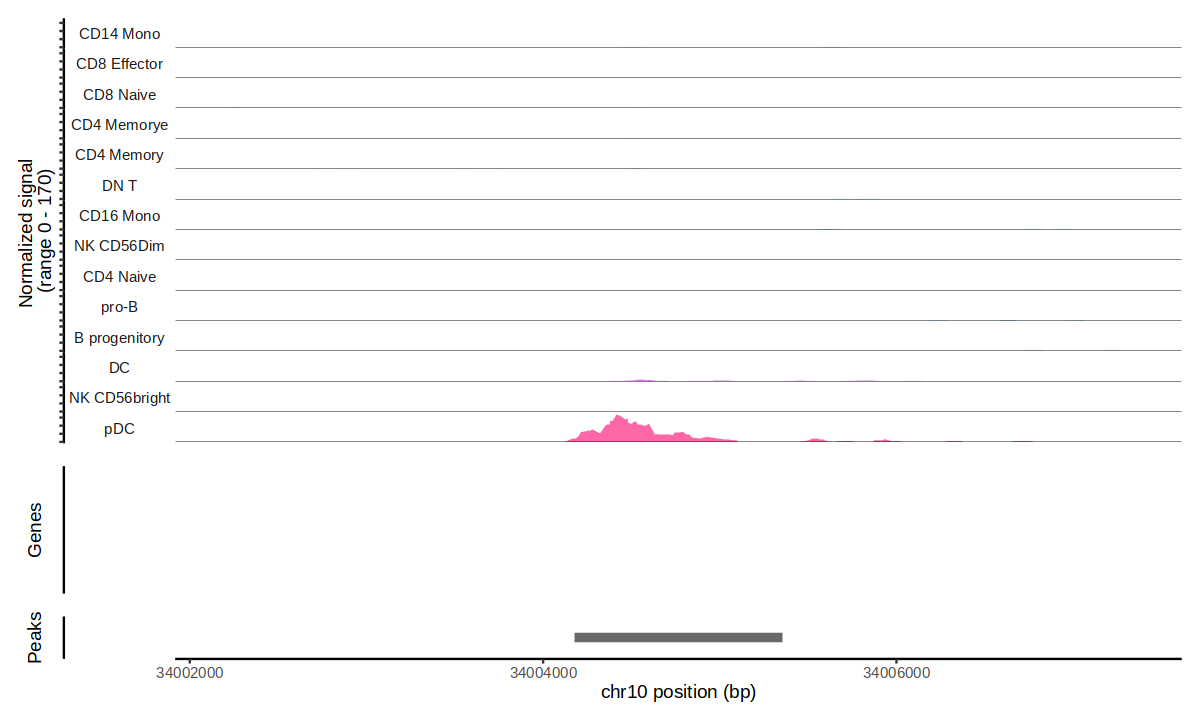

In [60]:
# set plotting order
#levels(seurat.object) <- c("CD4 Naive","CD4 Memory","CD8 Naive","CD8 Effector","DN T","NK CD56bright","NK CD56Dim","pre-B",'pro-B',"pDC","DC","CD14 Mono",'CD16 Mono')

CoveragePlot(
  object = seurat.object,
  region = rownames(da_peaks.pdc)[1],
  extend.upstream = 2000,
  extend.downstream = 2000
)

Warning message:
"Removed 29 rows containing missing values (`geom_segment()`)."
Warning message:
"Removed 2 rows containing missing values (`geom_segment()`)."
Warning message:
"Removed 35 rows containing missing values (`geom_segment()`)."
Warning message:
"Removed 63 rows containing missing values (`geom_segment()`)."
Warning message:
"Removed 1 rows containing missing values (`geom_segment()`)."
Warning message:
"Removed 50 rows containing missing values (`geom_segment()`)."
Warning message:
"Removed 1 rows containing missing values (`geom_segment()`)."


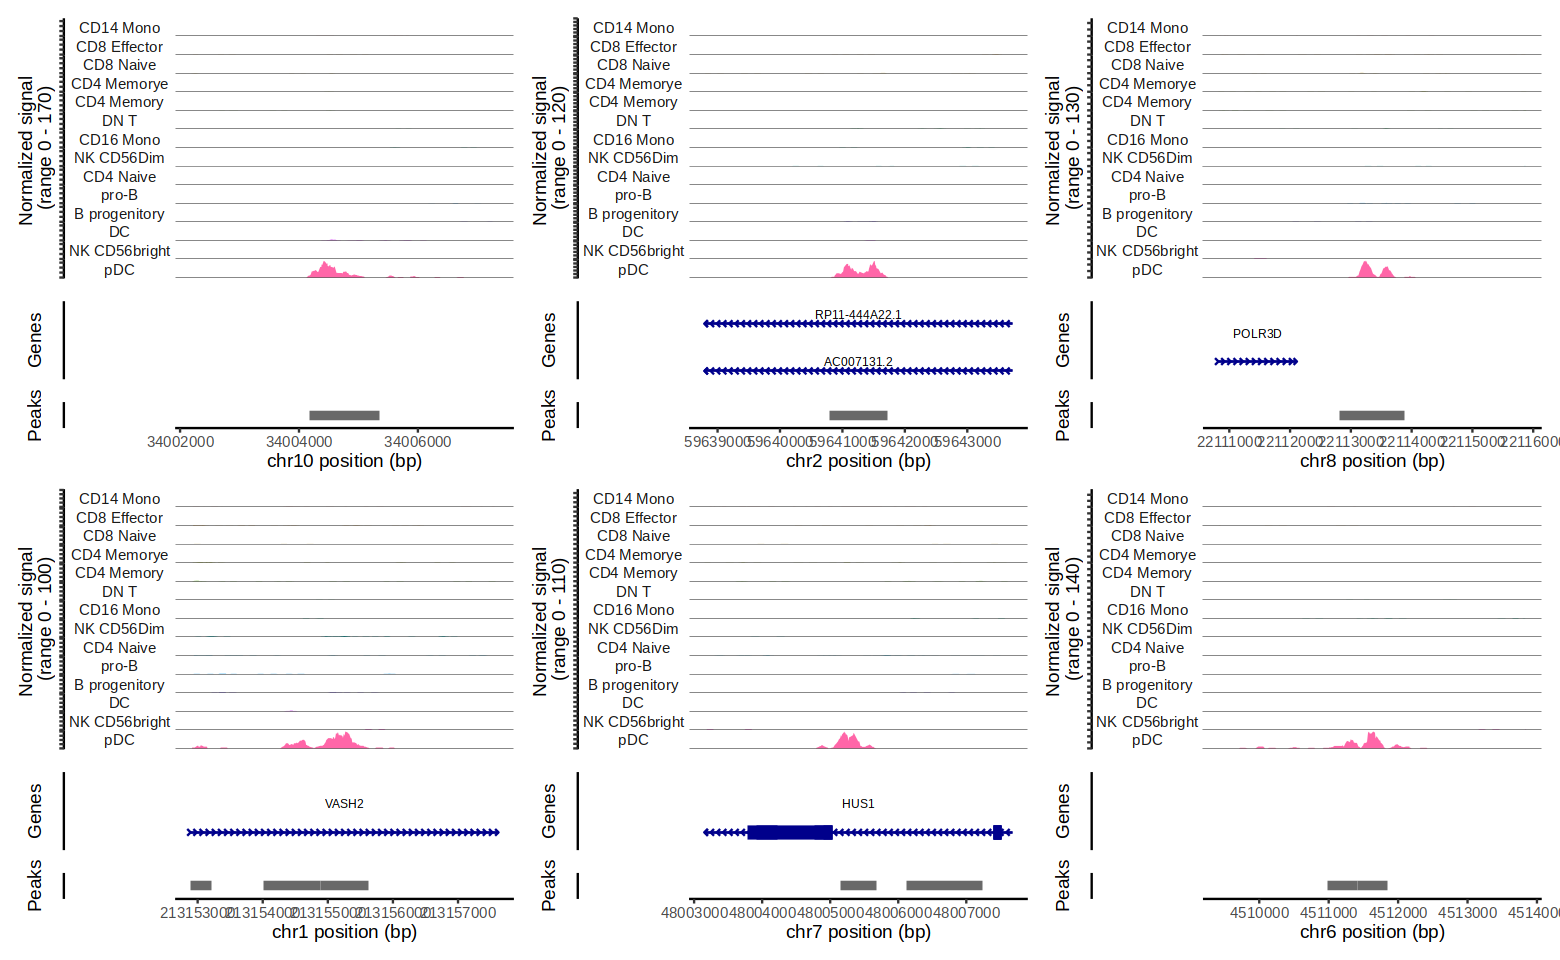

In [33]:
# set plotting order
#levels(seurat.object) <- c("CD4 Naive","CD4 Memory","CD8 Naive","CD8 Effector","DN T","NK CD56bright","NK CD56Dim","pre-B",'pro-B',"pDC","DC","CD14 Mono",'CD16 Mono')
DefaultAssay(seurat.object) <- 'peaks'
CoveragePlot(
  object = seurat.object,
  region = da_peaks.pdc%>%dplyr::filter(pct.2<=0.003)%>%rownames%>%head,
  extend.upstream = 2000,
  extend.downstream = 2000
)